In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math,os
from numpy.random import choice
import scikitplot as skplt
from time import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [5]:
historicalColumns,neighborColumns = [],[]

for historical in range(5):
    historicalColumns += ['Tminus'+str(historical+1)]

for neighbor in range(26):
    neighborColumns += ['T'+str(neighbor+1)+'_t-1']

columns = ['timestep','x_voxel','y_voxel','z_voxel','layerNum','time_creation','x_laser','y_laser','z_laser','x_distance','y_distance','z_distance','euclidean_distance_laser'] + historicalColumns+ neighborColumns+['T_self']



In [6]:
def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

def isEven(num):
    if num%2 ==0:
        return True
    return False

def modLog(num):
    try:
        return log(num)
    except:
        return 0

def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return np.load(fullPath)

In [19]:
featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns
featureDisplay = featureColumns

featureDisplay[7] = 'T_immediate_x-1'
featureDisplay[8] = 'T_immediate_x+1'
featureDisplay[9] = 'T_immediate_y-1'
featureDisplay[10] = 'T_immediate_y+1'
featureDisplay[11] = 'T_immediate_z-1'

featureDisplay[13] = 'T_immediate_x-1,y-1'
featureDisplay[14] = 'T_immediate_x-1,y+1'
featureDisplay[15] = 'T_immediate_x+1,y-1'
featureDisplay[16] = 'T_immediate_x+1,y+1'

featureDisplay[21] = 'T_immediate_x-1,z-1'

In [7]:
def plot_feature_importances(et):
    skplt.estimators.plot_feature_importances(et,text_fontsize=16,max_num_features=6,figsize=(24,4),feature_names=featureDisplay)

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
	'''
	scikit(sklearn) does not have support for mean absolute percentage error MAPE.
	This is because the denominator can theoretically be 0 and so the value would be undefined.
	So this is our implementation
	'''
# 	y_true = check_array(y_true)
# 	y_pred = check_array(y_pred)

	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def mse(y_true,y_pred):
    return roundup(mean_squared_error(y_true,y_pred))

def mae(y_true,y_pred):
    return roundup(mean_absolute_error(y_true,y_pred))

def mape(y_true, y_pred):
    return roundup(mean_absolute_percentage_error(y_true,y_pred))

In [9]:
def combineDataFrames(prefix,columns=columns):
    List = []
    nums_start,nums_stop = [],[]
    for item in os.listdir('data'):
        if "data_big" in item and ".npy" in item:
            timeStep_start = int(item.split('data_big_')[1].split('_')[0])
            nums_start += [timeStep_start]
            
            timeStep_stop = int(item.split('_')[3].split('.npy')[0])
            nums_stop += [timeStep_stop]
            
    nums_start = sorted(nums_start)
    nums_stop = sorted(nums_stop)
    
    array = loadNumpy('data/'+prefix+'_'+str(nums_start[0])+'_'+str(nums_stop[0])+'.npy')
    for i in range(1,len(nums_start)):
        newFile = 'data/'+prefix+'_'+str(nums_start[i])+'_'+str(nums_stop[i])+'.npy'
        array = np.append(array,loadNumpy(newFile),axis=0)
    return pd.DataFrame(array,columns=columns)

In [10]:
df_big = combineDataFrames('data_big')

In [73]:
df_train = df_big[df_big['timestep'] < 500.0]
df_test = df_big[df_big['timestep'] >= 500.0]


X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [74]:
et_500 = ExtraTreesRegressor(n_jobs=-1)
et_500.fit(X_train,y_train)
predicted = et_500.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.989, 0.6739)

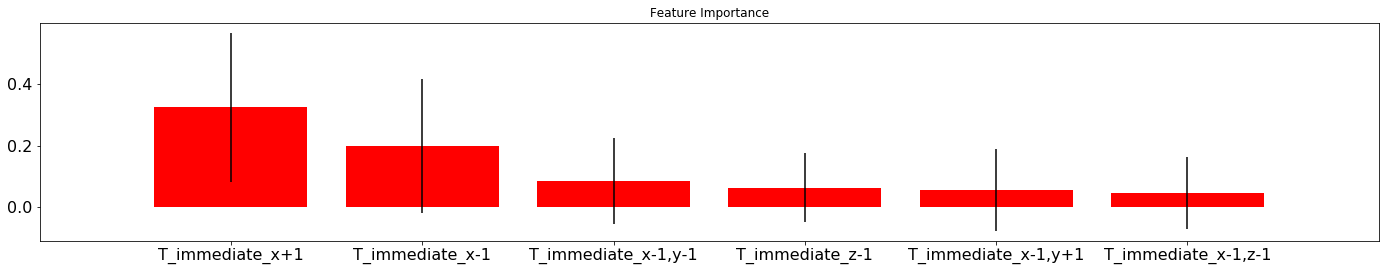

In [86]:
plot_feature_importances(et_500)

In [76]:
df_train = df_big[df_big['timestep'] < 300.0]
df_test = df_big[df_big['timestep'] >= 300.0]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

et_300 = ExtraTreesRegressor(n_jobs=-1)
et_300.fit(X_train,y_train)
predicted = et_300.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9817, 1.3283)

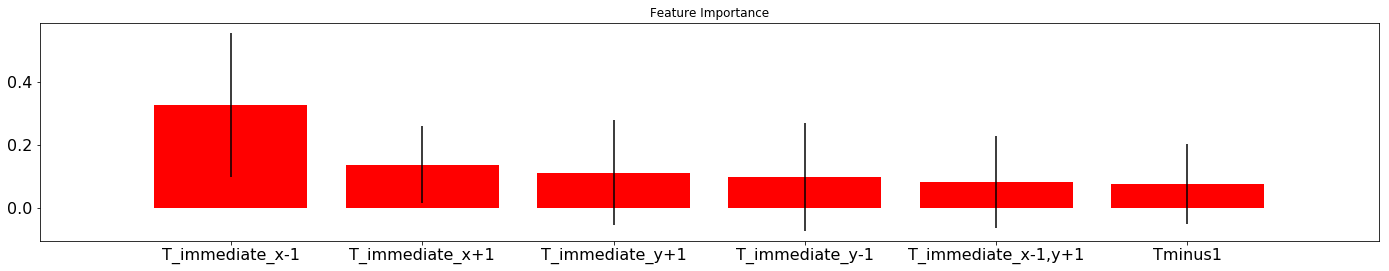

In [85]:
plot_feature_importances(et_300)

In [19]:
df_train = df_big[df_big['timestep'] < 200.0]
df_test = df_big[df_big['timestep'] >= 200.0]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

et_200 = ExtraTreesRegressor(n_jobs=-1)
et_200.fit(X_train,y_train)
predicted = et_200.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.9721, 1.8483)

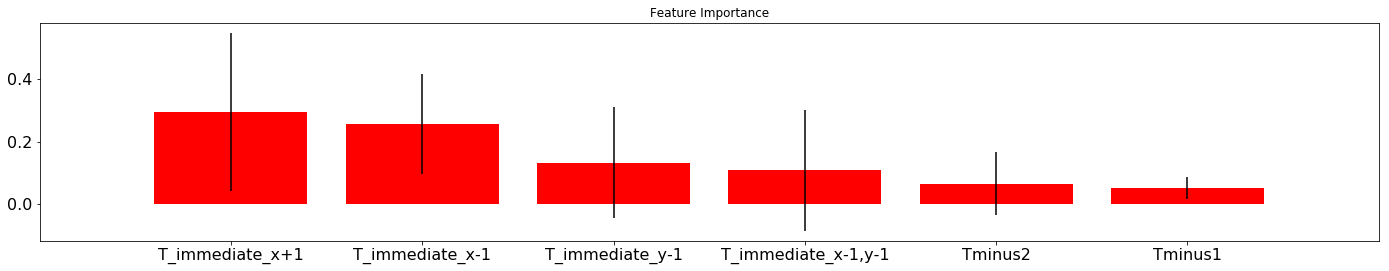

In [87]:
plot_feature_importances(et_200)

In [92]:
et_200_4 = ExtraTreesRegressor(n_estimators=4, n_jobs=-1,random_state=300)
start = time()
et_200_4.fit(X_train,y_train)
predicted = et_200_4.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  7.82032084465 seconds


(0.9611, 1.8844)

In [11]:
et_200_20 = ExtraTreesRegressor(n_estimators=20, n_jobs=-1,random_state=300)
start = time()
et_200_20.fit(X_train,y_train)
predicted = et_200_20.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  19.6388888359 seconds


(0.9721, 2.022)

In [12]:
df_train = df_big[df_big['timestep'] < 100.0]
df_test = df_big[df_big['timestep'] >= 100.0]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train = df_train.loc[:,featureColumns ]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns ]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

et_100 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
start = time()
et_100.fit(X_train,y_train)
predicted = et_100.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  4.42869782448 seconds


(0.9077, 4.6518)

In [17]:
et_100_10_depth1 = ExtraTreesRegressor(n_estimators=10, max_depth = 1, n_jobs=-1,random_state=300)
start = time()
et_100_10_depth1.fit(X_train,y_train)
predicted = et_100_10_depth1.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  1.3170440197 seconds


(0.4258, 15.6606)

In [16]:
et_100_10_mae = ExtraTreesRegressor(n_estimators=10, criterion='mae', n_jobs=-1,random_state=300)
start = time()
et_100_10_mae.fit(X_train,y_train)
predicted = et_100_10_mae.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  270.6014781 seconds


(0.9065, 4.9517)

In [14]:
et_100_50 = ExtraTreesRegressor(n_estimators=50, n_jobs=-1,random_state=300)
start = time()
et_100_50.fit(X_train,y_train)
predicted = et_100_50.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  17.5442438126 seconds


(0.9253, 4.2404)

In [15]:
et_100_100 = ExtraTreesRegressor(n_estimators=100, n_jobs=-1,random_state=300)
start = time()
et_100_100.fit(X_train,y_train)
predicted = et_100_100.predict(X_test)
stop = time()
print 'time elapsed ',(stop-start),'seconds'
r2(y_test,predicted) ,mape(y_test,predicted)

time elapsed  33.6085779667 seconds


(0.9283, 4.0228)

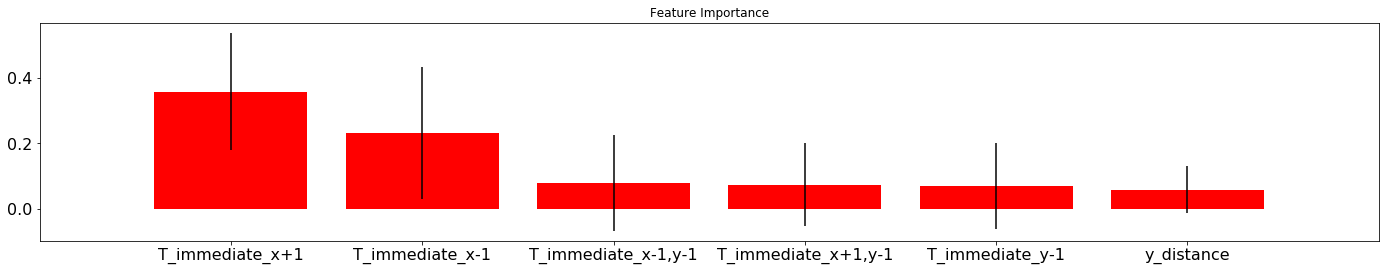

In [88]:
plot_feature_importances(et_100)

### Iterative Prediction 

In [50]:
df_train_1 = df_big[df_big.timestep < 50.0]
df_test_1 = df_big[(df_big.timestep >= 50.0) & (df_big.timestep < 100.0)]

featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train_1, y_train_1= shuffle(df_train_1.loc[:,featureColumns ], df_train_1['T_self'].values, random_state=300)
X_test_1,y_test_1 = shuffle(df_test_1.loc[:,featureColumns],df_test_1['T_self'],random_state=300)

et_1 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_1.fit(X_train_1,y_train_1)
y_predicted_1 = et_1.predict(X_test_1)
print('Iteration 1 over....')

X_train_2, y_train_2= X_train_1.append(X_test_1, ignore_index=True), np.append( y_train_1, y_predicted_1)
X_train_2,y_train_2 = shuffle(X_train_2,y_train_2,random_state=300)

df_test_2 = df_big[(df_big.timestep >= 100.0) & (df_big.timestep < 150.0)]
X_test_2,y_test_2 = shuffle(df_test_2.loc[:,featureColumns],df_test_2['T_self'],random_state=300)

et_2 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_2.fit(X_train_2,y_train_2)
y_predicted_2 = et_2.predict(X_test_2)
print('Iteration 2 over....')

X_train_3, y_train_3= X_train_2.append(X_test_2, ignore_index=True), np.append( y_train_2, y_predicted_2)
X_train_3,y_train_3 = shuffle(X_train_3,y_train_3,random_state=300)

df_test_3 = df_big[(df_big.timestep >= 150.0) & (df_big.timestep < 200.0)]
X_test_3,y_test_3 = shuffle(df_test_3.loc[:,featureColumns],df_test_3['T_self'],random_state=300)

et_3 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_3.fit(X_train_3,y_train_3)
y_predicted_3 = et_3.predict(X_test_3)
print('Iteration 3 over....')

X_train_4, y_train_4= X_train_3.append(X_test_3, ignore_index=True), np.append( y_train_3, y_predicted_3)
X_train_4,y_train_4 = shuffle(X_train_4,y_train_4,random_state=300)

df_test_4 = df_big[(df_big.timestep >= 200.0) & (df_big.timestep < 250.0)]
X_test_4,y_test_4 = shuffle(df_test_4.loc[:,featureColumns],df_test_4['T_self'],random_state=300)

et_4 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_4.fit(X_train_4,y_train_4)
y_predicted_4 = et_4.predict(X_test_4)
print('Iteration 4 over....')



print ('Iterative training results')
print r2(y_test_4,y_predicted_4) ,mape(y_test_4,y_predicted_4)

print ('One step training results')
et_direct = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_direct.fit(X_train_1,y_train_1)
y_predicted = et_direct.predict(X_test_4)

r2(y_test_4,y_predicted) ,mape(y_test_4,y_predicted)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iterative training results
0.9564 2.2001
One step training results


(0.9553, 2.1074)

In [88]:
df_big.tail()

,timestep,x_voxel,y_voxel,z_voxel,layerNum,time_creation,x_laser,y_laser,z_laser,x_distance,y_distance,z_distance,euclidean_distance_laser,Tminus1,Tminus2,Tminus3,Tminus4,Tminus5,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,T_self
9051647,1159.0,18.0,7.5,3.0,6.0,3.0,4.241559,3.75,5.0,13.758441,3.75,2.0,NaN,1190.41,1184.82,1177.17,1166.52,1153.81,1198.81,1190.14,1165.74,1147.50,1176.48,1185.88,1170.44,1152.12,1161.24,1143.29,1153.54,1132.42,1207.40,1148.52,1165.11,1155.52,1190.05,1182.07,1181.46,1137.23,1171.84,1132.93,1211.62,1158.62,1203.54,1150.47,1194.30
9051648,1159.0,17.5,15.5,2.0,4.0,2.0,4.241559,3.75,5.0,13.258441,11.75,3.0,NaN,1238.70,1248.22,1258.04,1268.75,1279.16,1226.71,1221.22,1197.65,1214.78,1199.74,1245.62,1205.20,1237.64,1196.62,1206.94,1182.40,1210.41,1210.40,1229.79,1219.26,1190.59,1241.88,1227.41,1190.85,1205.86,1179.43,1201.26,1217.24,1253.22,1210.93,1238.11,1229.46
9051649,1159.0,2.0,7.0,3.5,7.0,3.5,4.241559,3.75,5.0,2.241559,3.25,1.5,NaN,1136.82,1132.48,1132.48,1133.21,1133.72,1240.35,1236.93,1186.66,1239.37,1198.86,1164.83,1153.60,1185.41,1158.80,1187.63,1143.03,1165.17,1203.32,1274.46,1198.48,1198.82,1275.09,1272.05,1139.98,1162.81,1146.55,1167.66,1162.69,1202.53,1167.07,1203.47,1156.07
9051650,1159.0,3.5,12.5,2.5,5.0,2.5,4.241559,3.75,5.0,0.741559,8.75,2.5,NaN,1214.33,1220.64,1227.02,1233.86,1240.38,1199.99,1213.20,1172.97,1198.15,1196.39,1216.93,1166.89,1201.36,1187.27,1214.92,1164.36,1196.72,1179.57,1205.65,1189.17,1203.40,1210.72,1220.75,1157.74,1189.26,1170.79,1204.10,1182.21,1199.60,1185.22,1223.29,1208.11
9051651,1159.0,18.0,8.5,3.5,7.0,3.5,4.241559,3.75,5.0,13.758441,4.75,1.5,NaN,1156.85,1152.95,1148.43,1143.22,1138.31,1152.46,1145.15,1148.52,1154.35,1141.97,1151.92,1158.62,1164.27,1150.47,1156.23,1147.50,1152.27,1157.96,1164.26,1146.25,1138.32,1155.67,1148.72,1152.12,1156.82,1143.29,1148.12,1162.04,1168.28,1154.28,1160.62,1160.05


In [85]:
def compare_iterative_direct_prediction(n=5, init=100, TIMESTEP_ITER = 50, n_estimators=10):
    
    df_train_i_minus_1 = df_big[df_big.timestep < init]
    df_test_i_minus_1 = df_big[(df_big.timestep >= init) & (df_big.timestep < init+TIMESTEP_ITER)]

    X_train_i_minus_1, y_train_i_minus_1= shuffle(df_train_i_minus_1.loc[:,featureColumns ], df_train_i_minus_1['T_self'].values, random_state=300)
    X_test_i_minus_1,y_test_i_minus_1 = shuffle(df_test_i_minus_1.loc[:,featureColumns],df_test_i_minus_1['T_self'],random_state=300)

    et_i_minus_1 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
    start = time()
    et_i_minus_1.fit(X_train_i_minus_1,y_train_i_minus_1)
    y_predicted_i_minus_1 = et_i_minus_1.predict(X_test_i_minus_1)

    print('Iteration 1 over....')
    for i in range(2,n+1):
        X_train_i, y_train_i= X_train_i_minus_1.append(X_test_i_minus_1, ignore_index=True), np.append( y_train_i_minus_1, y_predicted_i_minus_1)
        X_train_i,y_train_i = shuffle(X_train_i,y_train_i,random_state=300)
        START = TIMESTEP_ITER * i
        STOP = TIMESTEP_ITER * (i+1)
        df_test_i = df_big[(df_big.timestep >= START) & (df_big.timestep < STOP)]
        X_test_i,y_test_i = shuffle(df_test_i.loc[:,featureColumns],df_test_i['T_self'],random_state=300)

        et_i = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
        et_i.fit(X_train_i,y_train_i)
        y_predicted_i = et_i.predict(X_test_i)
        print('Iteration '+str(i)+' over....')

    stop = time()
    print 'time elapsed for iterative is ',(stop-start),'seconds'

    print r2(y_test_i,y_predicted_i) ,mape(y_test_i,y_predicted_i)



    print ('One step training results')
    df_train_1 = df_big[df_big.timestep < TIMESTEP_ITER]
    X_train_1, y_train_1= shuffle(df_train_1.loc[:,featureColumns ], df_train_1['T_self'].values, random_state=300)
    start = time()
    et_direct = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
    et_direct.fit(X_train_1,y_train_1)
    y_predicted_direct = et_direct.predict(X_test_i)

    stop = time()
    print 'time elapsed for direct is ',(stop-start),'seconds'
    print r2(y_test_i,y_predicted_direct) ,mape(y_test_i,y_predicted_direct)

In [78]:
compare_iterative_direct_prediction(n=10,init=100,TIMESTEP_ITER=25)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
time elapsed for iterative is  10.5490999222 seconds
0.9353 2.1904
One step training results
time elapsed for direct is  0.306558847427 seconds
0.9212 3.565


In [77]:
compare_iterative_direct_prediction(n=15,init=150,TIMESTEP_ITER=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
time elapsed for iterative is  38.7692480087 seconds
0.9762 1.5699
One step training results
time elapsed for direct is  0.261981964111 seconds
0.5686 34.9248


In [79]:
compare_iterative_direct_prediction(n=20,init=100,TIMESTEP_ITER=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
time elapsed for iterative is  16.6568489075 seconds
0.9615 2.1783
One step training results
time elapsed for direct is  0.264371156693 seconds
0.632 23.6034


In [82]:
compare_iterative_direct_prediction(n=20,init=100,TIMESTEP_ITER=20)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
time elapsed for iterative is  20.8669538498 seconds
0.943 2.6316
One step training results
time elapsed for direct is  0.300190925598 seconds
0.906 5.7173


In [80]:
compare_iterative_direct_prediction(n=20,init=200,TIMESTEP_ITER=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
time elapsed for iterative is  109.798636198 seconds
0.992 0.6493
One step training results
time elapsed for direct is  0.266591072083 seconds
0.632 23.6034


In [81]:
compare_iterative_direct_prediction(n=20,init=200,TIMESTEP_ITER=20)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
time elapsed for iterative is  125.565798044 seconds
0.9801 1.3831
One step training results
time elapsed for direct is  0.299916982651 seconds
0.906 5.7173


In [83]:
compare_iterative_direct_prediction(n=40,init=200,TIMESTEP_ITER=20)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....
Iteration 31 over....
Iteration 32 over....
Iteration 33 over....
Iteration 34 over....
Iteration 35 over....
Iteration 36 over....
Iteration 37 over....
Iteration 38 over....
Iteration 39 over....
Iteration 40 over....
time elapsed for iterative is  257.478080988 seconds
0.9699 1.9535
One step training results
time elapsed for direct is  0.272726

In [86]:
compare_iterative_direct_prediction(n=40,init=200,TIMESTEP_ITER=20,n_estimators=4)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....
Iteration 31 over....
Iteration 32 over....
Iteration 33 over....
Iteration 34 over....
Iteration 35 over....
Iteration 36 over....
Iteration 37 over....
Iteration 38 over....
Iteration 39 over....
Iteration 40 over....
time elapsed for iterative is  154.503654957 seconds
0.9635 2.1472
One step training results
time elapsed for direct is  0.303838

In [87]:
compare_iterative_direct_prediction(n=40,init=200,TIMESTEP_ITER=25,n_estimators=4)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....
Iteration 31 over....
Iteration 32 over....
Iteration 33 over....
Iteration 34 over....
Iteration 35 over....
Iteration 36 over....
Iteration 37 over....
Iteration 38 over....
Iteration 39 over....
Iteration 40 over....
time elapsed for iterative is  175.837056875 seconds
0.9614 1.7012
One step training results
time elapsed for direct is  0.362329

In [60]:
compare_iterative_direct_prediction(10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
time elapsed for iterative is  10.0524089336 seconds
0.9276 3.2855
One step training results
time elapsed for direct is  0.38846206665 seconds
0.9263 3.0466


In [45]:
y_test_np = y_test_1.values

In [46]:
type(y_test_np)

numpy.ndarray

In [44]:
type(y_predicted_1), type(y_test_1)

(numpy.ndarray, pandas.core.series.Series)

In [34]:
r2(y_test_1,y_predicted_1) ,mape(y_test_1,y_predicted_1)

(0.9597, 1.9761)

In [46]:
displayColumns(X_train)

0 -> timestep
1 -> x_distance
2 -> y_distance
3 -> z_distance
4 -> layerNum
5 -> Tminus1
6 -> Tminus2
7 -> T1_t-1
8 -> T2_t-1
9 -> T3_t-1
10 -> T4_t-1
11 -> T5_t-1
12 -> T6_t-1
13 -> T7_t-1
14 -> T8_t-1
15 -> T9_t-1
16 -> T10_t-1
17 -> T11_t-1
18 -> T12_t-1
19 -> T13_t-1
20 -> T14_t-1
21 -> T15_t-1
22 -> T16_t-1
23 -> T17_t-1
24 -> T18_t-1
25 -> T19_t-1
26 -> T20_t-1
27 -> T21_t-1
28 -> T22_t-1
29 -> T23_t-1
30 -> T24_t-1
31 -> T25_t-1
32 -> T26_t-1
